The National Oceanic and Atmospheric Administration (NOAA) provides free acces to gridded meterological data from 1979 - 2016 via FTP/HTTPs. This data is part of the North American Regional Reanalysis (NARR) project which provides a comprehensive long term view of weather in North America. The NARR dataset is ideal for this project because it circumvents the need to scrape weather data from diffrent sources and bin it in house.

The data is provided by NOAA's Physical Science Division in netCDF format. Conveniently, we can use the python packages xarray and netCDF4 to read the data into a pandas dataframe.

Let's install those packages, grab a datafile from NOAA and see what we can do with it.

```
conda install xarray
conda install netcdf4
```

**Config. variables, to be moved out when notebook becomes finalized script**

In [1]:
# File paths
air_temp_data_file = '../data/NOAA_NARR_weather_data/air.sfc.2015.nc'
california_shapefile = '../data/spatial_data/cb_2018_us_state_500k.shp'
output_file = '../data/NOAA_NARR_weather_data/california_air_sfc_2015.csv'

# California bounding box coordinates
lat_start = 32.52
lon_start = -124.48
lat_end = 42.0
lon_end = -114.131

# Parallelization options
n_threads = 15
jobs_per_thread = 5

We will start with surface air temperatures from 2015 as a test case. The orignal data has ~280 million observations, is ~240M on disk and occupies 5.8G of memory as a pandas dataframe.

In [2]:
import xarray as xr

ds = xr.open_dataset(air_temp_data_file)
df = ds.to_dataframe()
df.info()

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282285160 entries, (2015-01-01 00:00:00, 0.0, 0.0) to (2015-12-31 21:00:00, 11297120.0, 8959788.0)
Data columns (total 4 columns):
lat                  float32
lon                  float32
Lambert_Conformal    int32
air                  float32
dtypes: float32(3), int32(1)
memory usage: 5.8 GB


In [3]:
df.head()

lat         lon  Lambert_Conformal         air
time       x   y                                                            
2015-01-01 0.0 0.0       1.000001 -145.500000        -2147483647  299.414612
               32463.0   1.184838 -145.604706        -2147483647  299.414612
               64926.0   1.369977 -145.710007        -2147483647  299.414612
               97389.0   1.555408 -145.815796        -2147483647  299.477112
               129852.0  1.741138 -145.922104        -2147483647  299.477112

Clean up unnecessary columns and fix index.

In [4]:
df.index = df.index.droplevel([1, 2])                 # Drop x and y cooridnate index and 
#df.set_index(['lat', 'lon'], inplace=True)           # and use latitude and longitude instead
df.drop(['Lambert_Conformal'], axis=1, inplace=True) 
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277473000 entries, 2015-01-01 00:00:00 to 2015-12-31 21:00:00
Data columns (total 3 columns):
lat    float32
lon    float32
air    float32
dtypes: float32(3)
memory usage: 5.2 GB


In [5]:
df.head()

,lat,lon,air
time,,,
2015-01-01,1.000001,-145.500000,299.414612
2015-01-01,1.184838,-145.604706,299.414612
2015-01-01,1.369977,-145.710007,299.414612
2015-01-01,1.555408,-145.815796,299.477112
2015-01-01,1.741138,-145.922104,299.477112


The dataset encompases all of North America. Therefore, we need to discard points outside of California. This will be done in two steps:

1. Threshold by latitude and longitude to get a rectangle of points encompasing California.
2. Use geopandas and shaply to get points inside California polygon.

The first step removes ~99% of the data in just a few seconds saving hours on the shaply operation.

In [6]:
df = df.loc[(df['lat'] >= lat_start) & (df['lat'] <= lat_end)]
df = df.loc[(df['lon'] >= lon_start) & (df['lon'] <= lon_end)]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2806120 entries, 2015-01-01 00:00:00 to 2015-12-31 21:00:00
Data columns (total 3 columns):
lat    float32
lon    float32
air    float32
dtypes: float32(3)
memory usage: 53.5 MB


In [7]:
df.head()

,lat,lon,air
time,,,
2015-01-01,32.711090,-124.295998,290.789612
2015-01-01,32.983780,-124.372597,290.539612
2015-01-01,33.256741,-124.449898,290.289612
2015-01-01,32.774681,-123.971802,290.602112
2015-01-01,33.047729,-124.046997,290.414612


As you can see, we are now down to a much more mamagable size: 2,8 million observations and 53.3 MB in memory. Next step is to load California as a polygon object and use shaply to keep only the points which are within California's boarders.

In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from shapely.geometry import MultiPolygon, Polygon, Point
%matplotlib inline

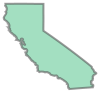

In [11]:
gdf = gpd.read_file(california_shapefile)
california = gdf[gdf['NAME'] == 'California']
multipoly = california.loc[16, 'geometry']
california = multipoly[-1]
california

In [13]:
# empty series to be returned in place of a point
# which is outside of californa
empty = pd.Series([np.nan, np.nan])
empty.index = ['lon', 'lat']

def is_california_point(point):
    '''Takes point and returns point if in california'''
    coord = Point(point['lon'], point['lat'])
    if coord.within(california) == True:
        return point
    else:
        return empty
    
def keep_california_points(df):
    '''Takes a dataframe containing and uses apply to
    run a function on it. Called by parallelize.'''
    keepers = df.apply(is_california_point, axis=1)
    return keepers
    
def parallelize(function, df, n_threads):
    '''Parallelizes a function. Takes function name, dataframe
    and number of threads. Splits up function call over
    avalible threads. Joins and returns the results.'''  
    df_split = np.array_split(df, (n_threads * jobs_per_thread))
    with Pool(n_threads) as pool:
        result = pd.concat(pool.imap(function, df_split))
                                           
    pool.close()
    pool.join()
    return result
                              
%time df = parallelize(keep_california_points, df, n_threads).dropna() # Wall time: 4h 8min 10s on raw data
                                                                       # Wall time: 8min 35s on thresholded data
    
df.to_csv(output_file, header = True)

CPU times: user 388 ms, sys: 306 ms, total: 694 ms
Wall time: 3min 3s


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1197200 entries, 2015-01-01 00:00:00 to 2015-12-31 21:00:00
Data columns (total 3 columns):
air    1197200 non-null float64
lat    1197200 non-null float64
lon    1197200 non-null float64
dtypes: float64(3)
memory usage: 36.5 MB


In [17]:
df.head()

,air,lat,lon
time,,,
2015-01-01,287.102112,40.297489,-124.340797
2015-01-01,280.914612,38.961529,-123.557899
2015-01-01,282.102112,39.241501,-123.639297
2015-01-01,282.102112,39.521629,-123.721497
2015-01-01,279.352112,39.801929,-123.804497


Let's grab all of the California temperatures at one specific time to take a closer look.

In [18]:
df_one_hour = df.loc['2015-03-23 18:00:00']
df_one_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 410 entries, 2015-03-23 18:00:00 to 2015-03-23 18:00:00
Data columns (total 3 columns):
air    410 non-null float64
lat    410 non-null float64
lon    410 non-null float64
dtypes: float64(3)
memory usage: 12.8 KB


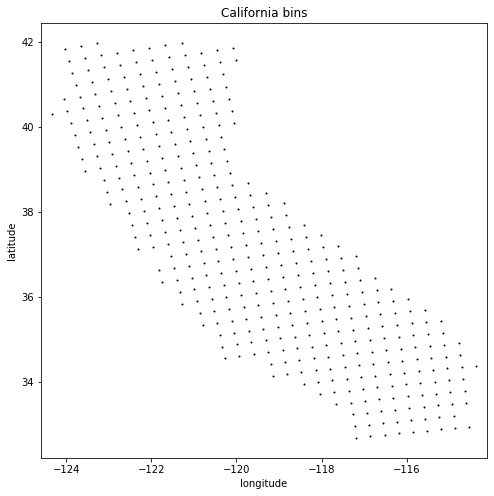

In [19]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = df_one_hour['lon'], y = df_one_hour['lat'], color = 'black', s = 1)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California bins')
plt.show()

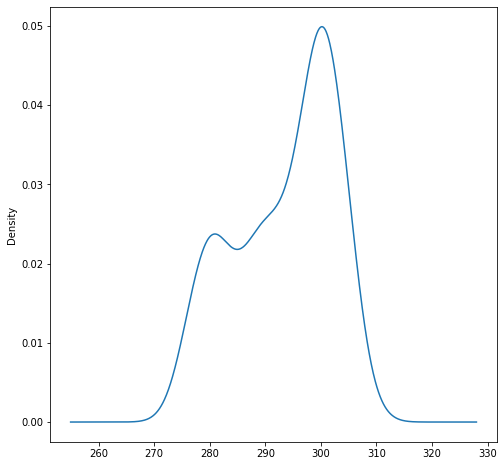

In [21]:
ax = df_one_hour.air.plot.kde()